### SPH-Interpolators
`sph-lib` allows to interpolate fields from tracers (particles) to arbitrary coordinates using the SPH gather method.
The central class is `sph_interpolator` which is initialized as follows
- `particle_positions`: particle positions of shape (N, dim). By default, we assume that particles are within [0, boxsize]
- `particle_masses`:  particle masses of shape (N,)
- `boxsize`:    boxsize of periodic box; **IF** specified assume periodicity, **ELSE** assumes data is non-periodic.
- `number_of_nn`: number of nearest neighbors to use when interpolating

The central routine is the `interpolate_fields_at_positions` function, that takes as input a single or a list of field values (`particle_field`) and the query coordinates.
It returns the interpolated field values at those positions.

The class internally computes the smoothing lengths and densities of tracer particles, which can be accessed as `interpolator.rho`. Depending on whether 2d or 3d positions are provided, this is either the surface or full 3d density.

In [ ]:
import numpy as np
import pynbody as pn
import matplotlib.pyplot as plt

from sph_lib.interpolation import sph_interpolator
from sph_lib.utils import create_grid_2d, create_grid_3d, shift_particle_positions

plt.style.use('../../mnras')
%matplotlib inline
%config InlineBackend.figure_format='retina'

### Load particle data and setup grid coordinates

In [ ]:
# load some sample data, set boxsize and number of neighbors
ds = pn.load('../../../data/snapshot_176_128.hdf5')
boxsize = 15000
NN = 64

# access the positions and relevant fields to interpolate
pos    = ds.gas['pos']
masses = ds.gas['mass']
temp   = ds.gas['temp']

# the code assumes that all positions are within [0, boxsize]
# you can use the utility function shift_particle_positions if needed
pos    = shift_particle_positions(pos)

# define some query coordinates, here we sample a regular grid
nx = 120
grid_2d = create_grid_2d(nx, nx, boxsize)
grid_3d = create_grid_3d(nx, nx, nx, boxsize)

/opt/anaconda3/envs/my_env/lib/python3.12/site-packages/pynbody/snapshot/gadgethdf.py:635: RuntimeWarning: No unit information found in GadgetHDF file. Using gadget default units.
  warnings.warn("No unit information found in GadgetHDF file. Using gadget default units.", RuntimeWarning)
/opt/anaconda3/envs/my_env/lib/python3.12/site-packages/pynbody/snapshot/gadgethdf.py:469: UserWarning: Unable to infer units from HDF attributes
  warnings.warn("Unable to infer units from HDF attributes")


### Interpolation: 2d
Let's interpolate the surface density $\sigma$ and temperature field onto arbitrary coordinates. Note that here we use equidistant grids for simplicity but interpolation onto arbitrary coordinates is possible.

In [3]:
# lets use the particles in a slab of 10% boxsize width to interpolate the values at grid coordinates
mask = np.logical_and(pos[:, -1] > 13500,
                      pos[:, -1] < 15000)
pos_masked    = pos[mask]
masses_masked = masses[mask]
temp_masked   = temp[mask]

Interpolator = sph_interpolator(
                                pos_masked[:, :2],
                                masses_masked, 
                                boxsize, 
                                NN
                                )

Computing 2d smoothing lengths and densities...


In [4]:
# Pass the fields to interpolate as a list
σ = Interpolator.rho
fields_to_interpolate = [σ, temp_masked]

field_values = Interpolator.interpolate_fields_at_positions(
                                    fields_to_interpolate, 
                                    grid_2d
                                    )

# The code returns an array of field values according to the coordinates, shape = (num_fields, num_coords)
# Reshape them for plotting
σ_grid  = field_values[0].reshape((nx, nx))
t_grid  = field_values[1].reshape((nx, nx))

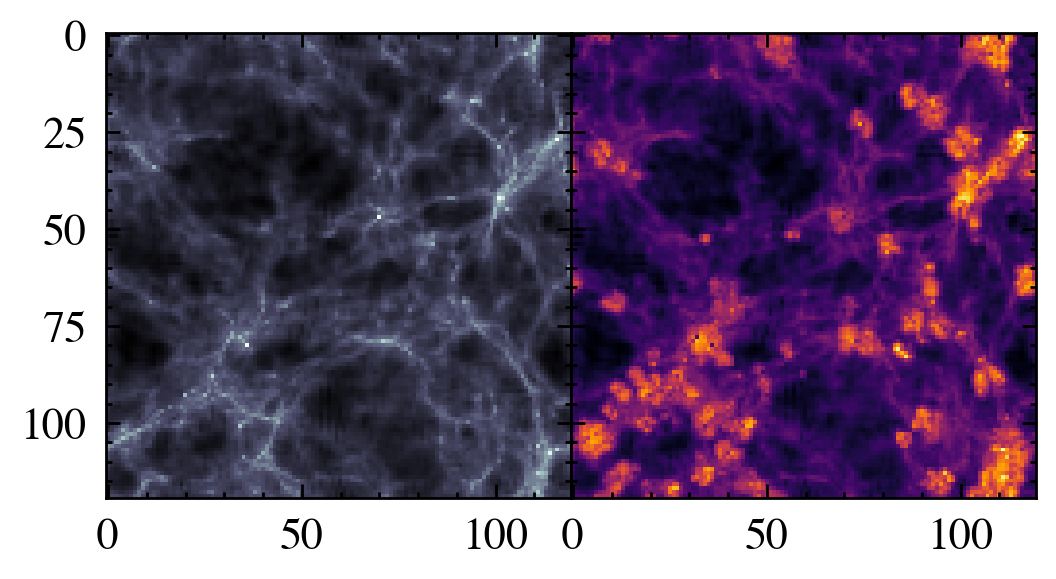

In [5]:
fig, ax = plt.subplots(1, 2, figsize=(3, 2), sharex=True, sharey=True)
ax[0].imshow(np.log10(σ_grid), cmap='bone')
ax[1].imshow(np.log10(t_grid), cmap='inferno')

plt.savefig('../figures/interpolation_2d.png', transparent=True, dpi=300)
plt.show()

In [6]:
total_mass_sim = masses_masked.sum()
total_mass_grid = σ_grid.mean() * boxsize**2
print('Difference in sampled mass vs total particle mass:', abs(100 * (1-total_mass_sim / total_mass_grid)), '%')

Difference in sampled mass vs total particle mass: 0.42895460173033584 %


### Interpolation with different kernels (2D case)

In [7]:
kernels = ['gaussian', 
           'super_gaussian', 
           'cubic_spline', 
           'quintic_spline', 
           'wendland_c2', 
           'wendland_c4', 
           'wendland_c6'
           ]
fields  = [] 
for kernel in kernels:
    Interpolator = sph_interpolator(
                                    pos_masked[:, :2],
                                    masses_masked, 
                                    boxsize, 
                                    NN,
                                    kernel=kernel
                                    )

    # The code casts the fields to a list if necessary, i.e. we can pass a single field
    fields_to_interpolate = Interpolator.rho
    field_values = Interpolator.interpolate_fields_at_positions(
                                                fields_to_interpolate, 
                                                grid_2d
                                                )
    fields.append(field_values[0].reshape((nx, nx)))

Computing 2d smoothing lengths and densities...
Computing 2d smoothing lengths and densities...
Computing 2d smoothing lengths and densities...
Computing 2d smoothing lengths and densities...
Computing 2d smoothing lengths and densities...
Computing 2d smoothing lengths and densities...
Computing 2d smoothing lengths and densities...


In [8]:
for kernel, field in zip(kernels, fields):
    print(f'Total mass using {kernel}: \t {field.sum()}' )

Total mass using gaussian: 	 0.03333607221368011
Total mass using super_gaussian: 	 0.035505321272814735
Total mass using cubic_spline: 	 0.03406926909214175
Total mass using quintic_spline: 	 0.0335866932257727
Total mass using wendland_c2: 	 0.033842912961307724
Total mass using wendland_c4: 	 0.03386093336687955
Total mass using wendland_c6: 	 0.033892419140317306


In [9]:
fov = np.s_[:, :fields[0].shape[0] // 2]
fields_fov = [f[fov] for f in fields]

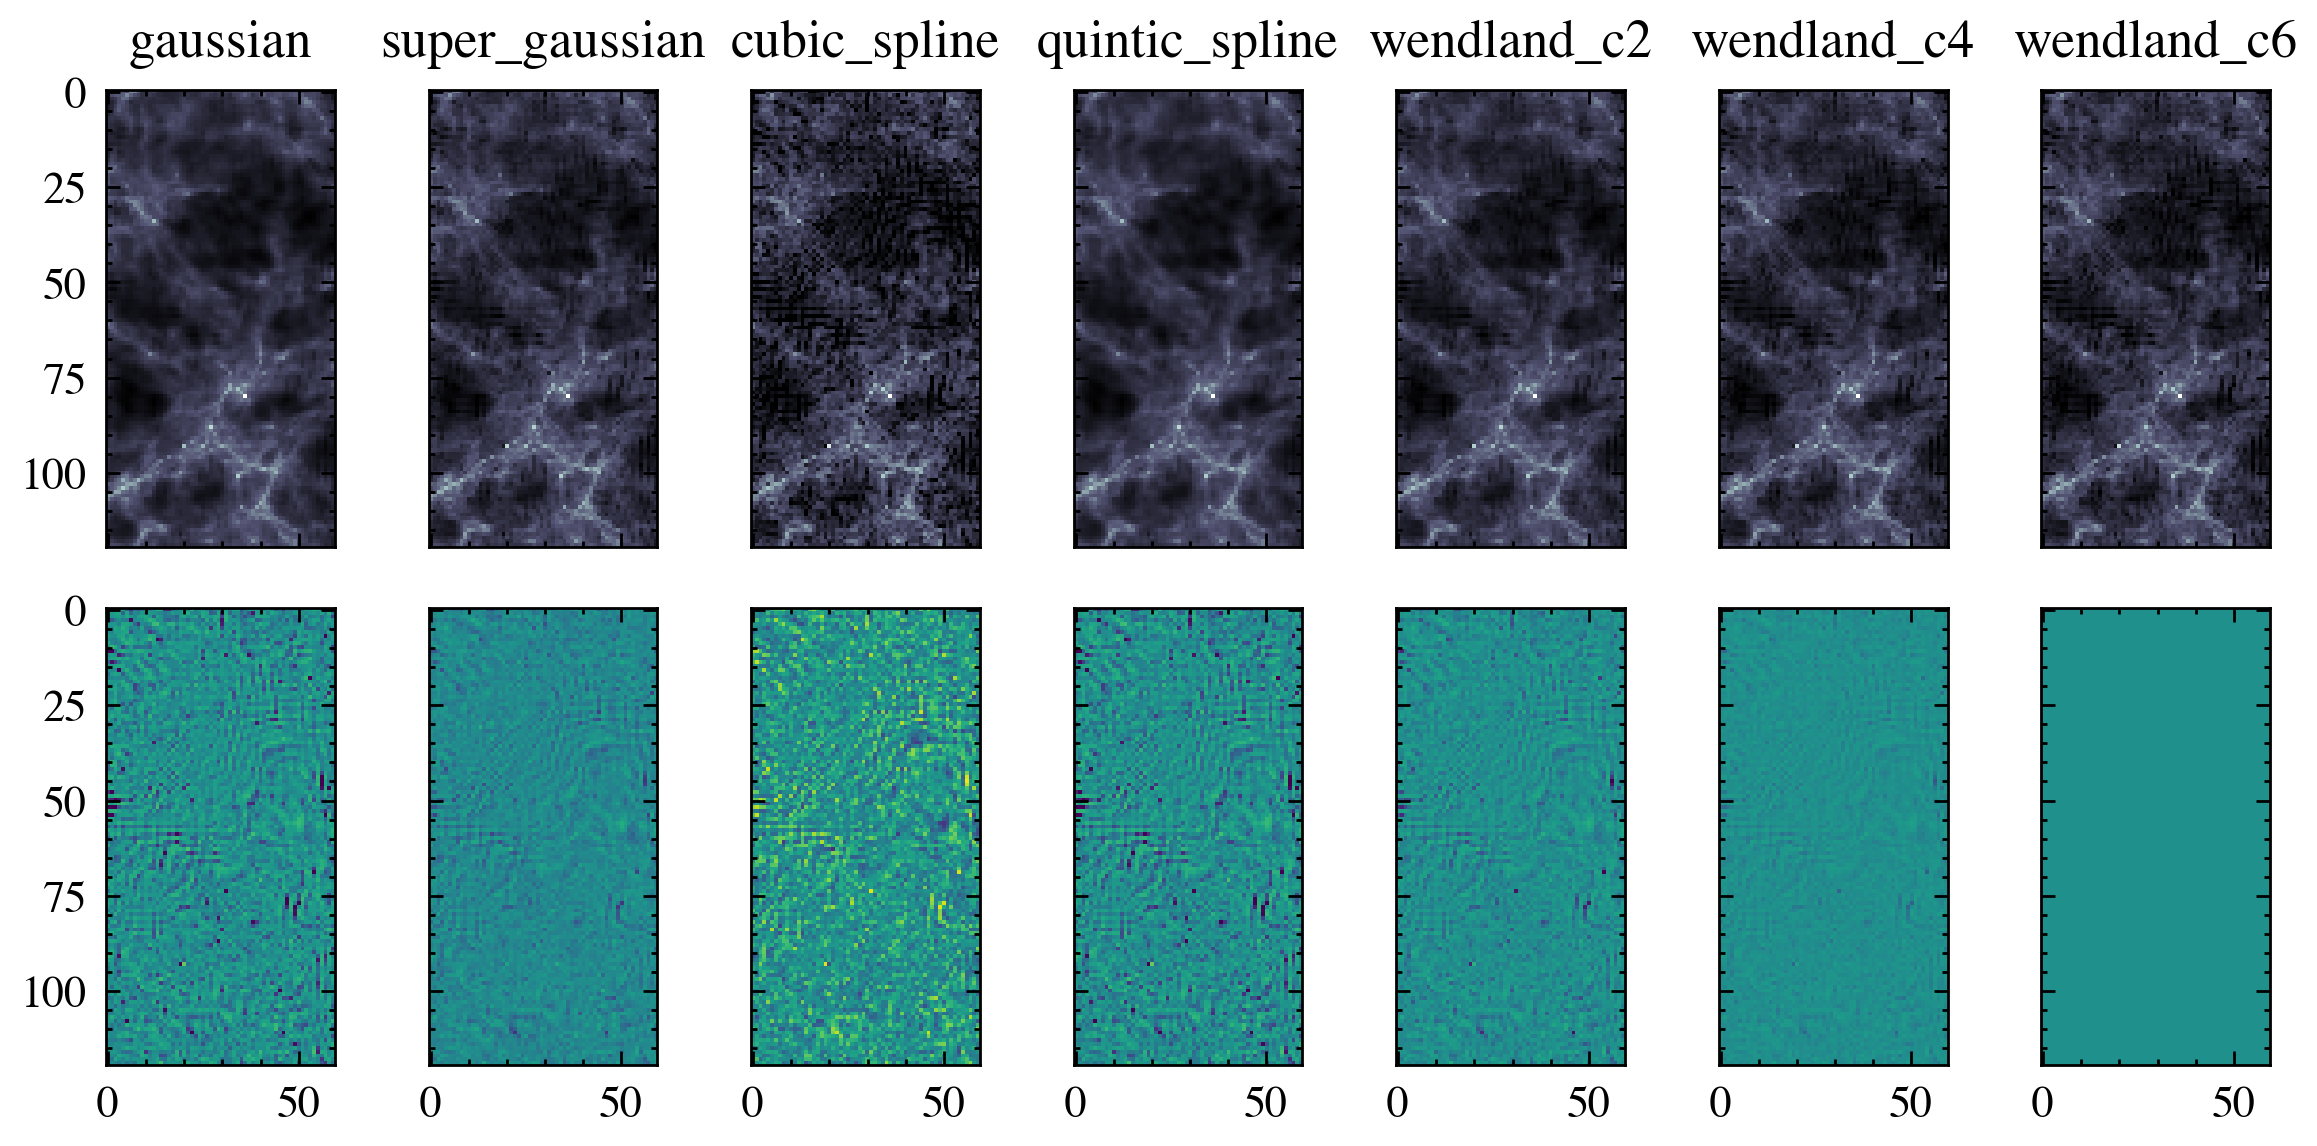

In [16]:
fig, ax = plt.subplots(2, len(kernels), figsize=(6, 3), sharex=True, sharey=True)

for i in range(len(kernels)):
    ax[0, i].imshow(np.log10(fields_fov[i]), 
                    cmap='bone',
                    vmin=np.log10(fields_fov[0]).min(),
                    vmax=np.log10(fields_fov[0]).max())
    
    ax[1, i].imshow(1 - fields_fov[i] / fields_fov[-1], cmap='viridis',
                    vmin=-1, vmax=1)
    ax[0, i].set(title=kernels[i])

plt.tight_layout()
plt.savefig('../figures/interpolation_2d_kernel_comparison.png', transparent=True, dpi=300)
plt.show()

### Interpolation: 3d
The difference between 2d and 3d interpolation is the computation of the smoothing length and densities of particles, which is either computing the 2d "surface" smoothing circle or 3d smoothing sphere.

In [11]:
Interpolator = sph_interpolator(pos, masses, boxsize, NN)

ρ = Interpolator.rho
fields_to_interpolate = [ρ, temp]

field_values = Interpolator.interpolate_fields_at_positions(fields_to_interpolate, grid_3d)

ρ_grid  = field_values[0].reshape((nx, nx, nx))
t_grid  = field_values[1].reshape((nx, nx, nx))


Computing 3d smoothing lengths and densities...


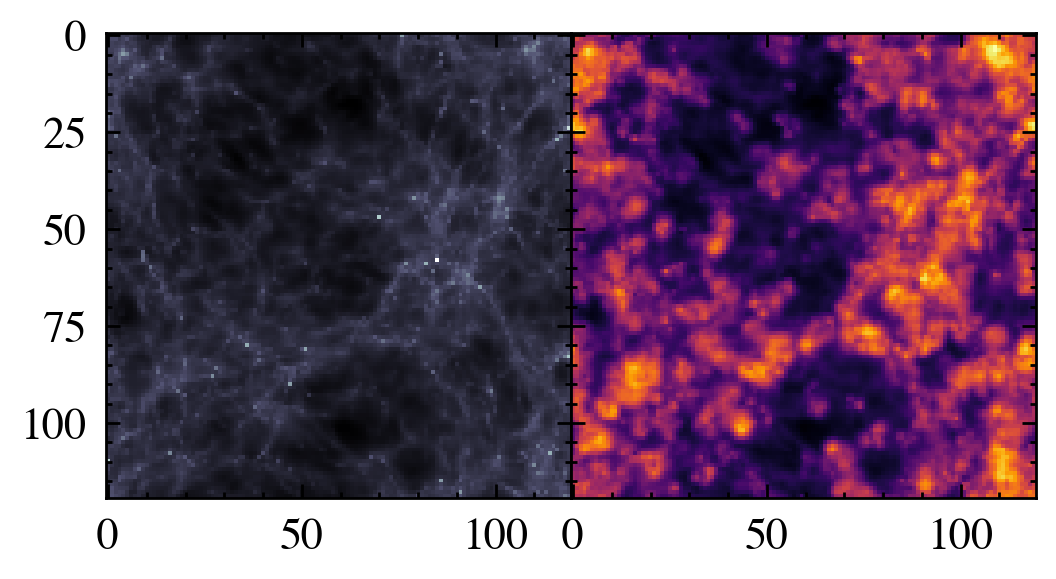

In [12]:
fig, ax = plt.subplots(1, 2, figsize=(3, 2), sharex=True, sharey=True)
ax[0].imshow(np.log10(ρ_grid.sum(axis=-1)), cmap='bone')
ax[1].imshow(np.log10(t_grid.sum(axis=-1)), cmap='inferno')

plt.savefig('../figures/interpolation_3d.png', transparent=True, dpi=300)
plt.show()

In [13]:
total_mass_sim = masses.sum()
total_mass_grid = ρ_grid.mean() * boxsize**3

print('Difference in sampled mass:', abs(100 * (1-total_mass_sim / total_mass_grid)), '%')

Difference in sampled mass: 0.7851311179594367 %


### Interpolating gradients of fields

In [14]:
grad_rho = Interpolator.interpolate_gradients_at_positions(Interpolator.rho, grid_3d)
grad_rho_grid  = grad_rho.reshape((1, nx, nx, nx, 3))

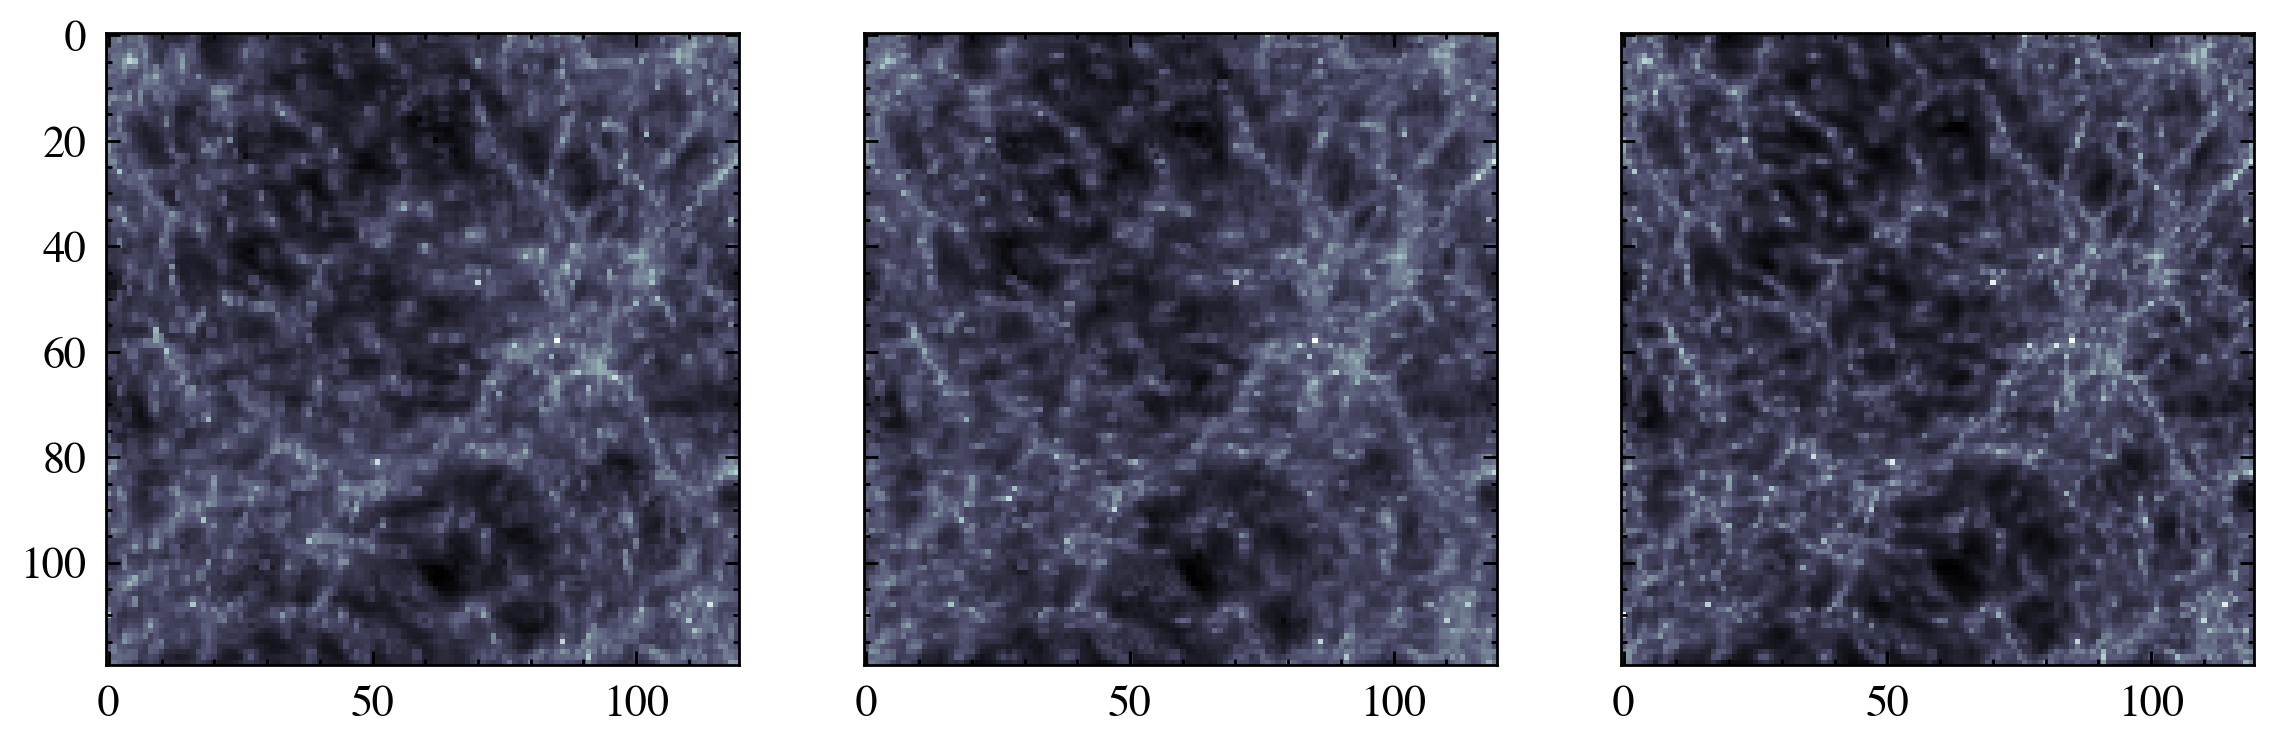

In [15]:
fig, ax = plt.subplots(1, 3, figsize=(6, 2), sharex=True, sharey=True)
ax[0].imshow(np.log10(np.abs(grad_rho_grid[0,...,0]).mean(-1)), cmap='bone')
ax[1].imshow(np.log10(np.abs(grad_rho_grid[0,...,1]).mean(-1)), cmap='bone')
ax[2].imshow(np.log10(np.abs(grad_rho_grid[0,...,2]).mean(-1)), cmap='bone')

plt.tight_layout()
plt.savefig('../figures/interpolation_3d_gradients.png', transparent=True, dpi=300)
plt.show()